In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2025-03-31 00:26:31.511249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743360991.531405   37107 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743360991.536662   37107 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743360991.550907   37107 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743360991.550924   37107 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743360991.550926   37107 computation_placer.cc:177] computation placer alr

In [3]:
# Set paths
DATASET_PATH = os.path.join('data')
TRAIN_CSV = os.path.join(DATASET_PATH, 'train.csv')
TEST_CSV = os.path.join(DATASET_PATH, 'test.csv')
TRAIN_PATH = os.path.join(DATASET_PATH, 'train_data')
TEST_PATH = os.path.join(DATASET_PATH, 'test_data_v2')

# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Check dataset
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print(train_df.head())

Train dataset shape: (79950, 3)
Test dataset shape: (5540, 1)
   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


In [4]:
# Drop rows with missing values
train_df = train_df.dropna().reset_index(drop=True)
test_df = test_df.dropna().reset_index(drop=True)

print(f"After dropping NaN: Train shape: {train_df.shape}, Test shape: {test_df.shape}")

After dropping NaN: Train shape: (79950, 3), Test shape: (5540, 1)


In [5]:
print(train_df.columns)
print(test_df.columns)

Index(['Unnamed: 0', 'file_name', 'label'], dtype='object')
Index(['id'], dtype='object')


In [6]:
train_df['label'].value_counts()

label
1    39975
0    39975
Name: count, dtype: int64

In [7]:
# Extract image paths and labels correctly
train_df["file_name"] = train_df["file_name"].apply(lambda x: os.path.join(DATASET_PATH, "train_data", os.path.basename(x)))
test_df["id"] = test_df["id"].apply(lambda x: os.path.join(DATASET_PATH, "test_data_v2", os.path.basename(x)))

# Split into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_df['file_name'].values, train_df['label'].values, test_size=0.2, random_state=42, stratify=train_df['label']
)

print(f"Training samples: {len(train_paths)}, Validation samples: {len(val_paths)}")

Training samples: 63960, Validation samples: 15990


In [8]:
train_labels = pd.get_dummies(train_labels).astype(int)
val_labels = pd.get_dummies(val_labels).astype(int)

In [9]:
train_labels

,0,1
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0
...,...,...
63955,0,1
63956,0,1
63957,1,0
63958,1,0


In [10]:
print("Any NaN in train paths?", pd.isna(train_paths).sum())
print("Any NaN in train labels?", pd.isna(train_labels).sum())

Any NaN in train paths? 0
Any NaN in train labels? 0    0
1    0
dtype: int64


In [11]:
# Image size required for EfficientNet
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Function to load and preprocess images
def load_image(image_path, label=None):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure RGB
    image = tf.image.resize(image, IMG_SIZE)  # Resize to EfficientNet input size
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize [0,1]
    
    # Return (image, label) for training, (image) for test
    return (image, label) if label is not None else image

# Data augmentation function (for training only)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.2)
    return image, label

In [12]:
# Create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(augment, num_parallel_calls=AUTOTUNE)  # Augment training data
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create validation dataset (no augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Datasets prepared successfully!")

Datasets prepared successfully!


I0000 00:00:1743361021.238559   37107 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2784 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [13]:
from tensorflow.keras import layers, models

# Load EfficientNetB0 (Pretrained on ImageNet, without top layers)
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Convert feature maps to vector
    layers.Dense(256, activation="relu"),  # Fully connected layer
    layers.Dropout(0.3),  # Dropout to reduce overfitting
    layers.Dense(2, activation="softmax")  # Output layer
])

In [14]:
# Compile the model
from tensorflow.keras.metrics import Precision, Recall, AUC

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [15]:
MODEL_PATH = os.path.join('model', 'best_model.keras')

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor="val_accuracy", mode="max")

# Train the Model
# history = model.fit(
#     train_dataset,
#     validation_data = val_dataset,
#     epochs=20,  # Adjust based on performance
#     callbacks=[early_stopping, model_checkpoint]
# )

In [17]:
model = keras.models.load_model(MODEL_PATH)

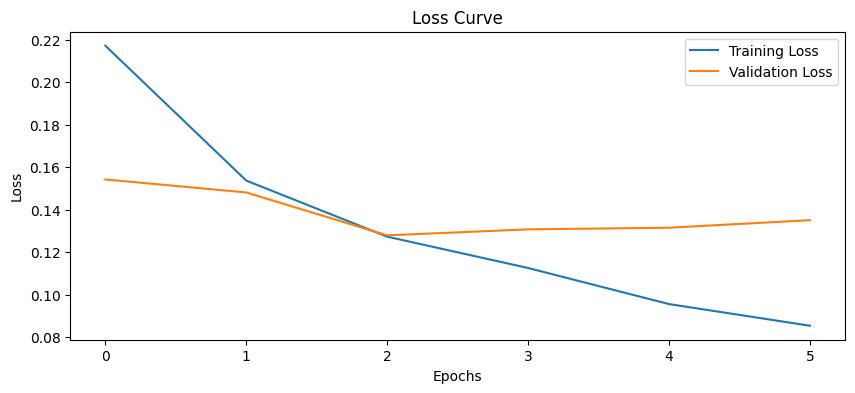

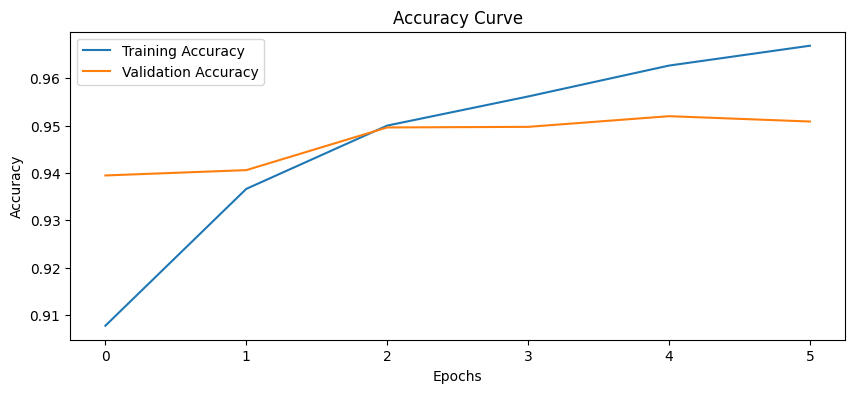

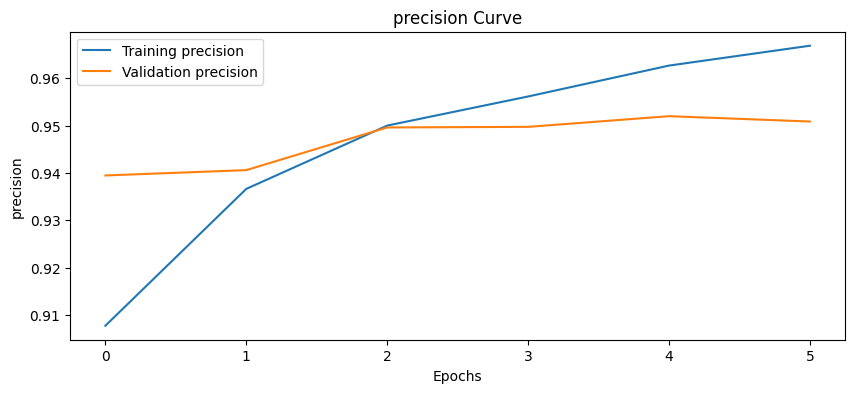

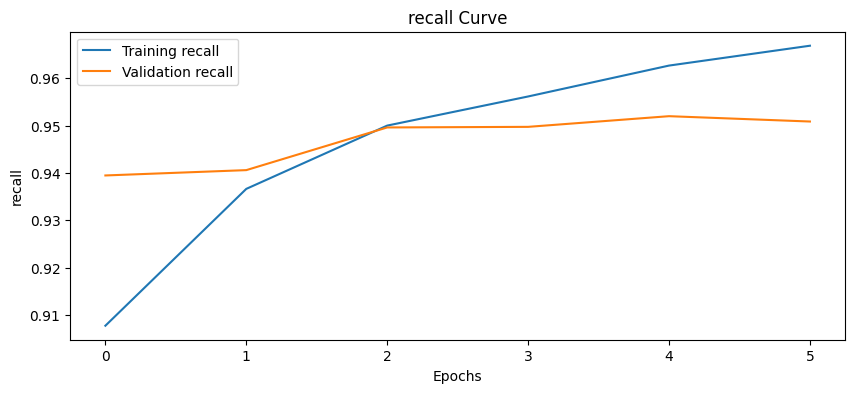

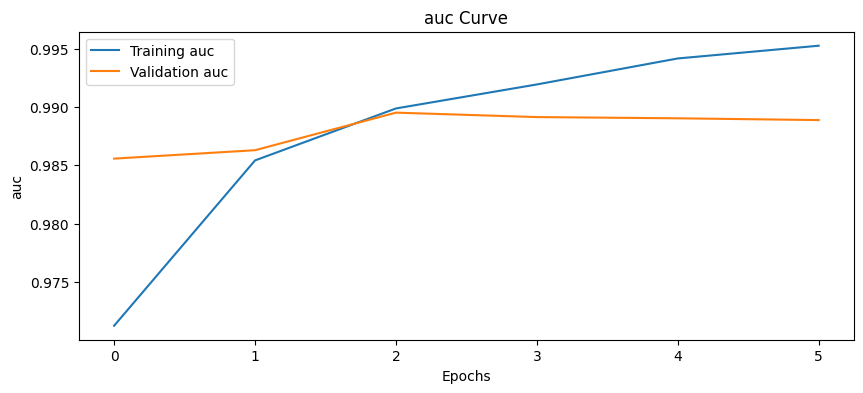

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert history to DataFrame for easy plotting
history_df = pd.DataFrame(history.history)

# Plot Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["loss"], label="Training Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["accuracy"], label="Training Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

# Plot precision Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["precision"], label="Training precision")
plt.plot(history_df["val_precision"], label="Validation precision")
plt.xlabel("Epochs")
plt.ylabel("precision")
plt.legend()
plt.title("precision Curve")
plt.show()

# Plot recall Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["recall"], label="Training recall")
plt.plot(history_df["val_recall"], label="Validation recall")
plt.xlabel("Epochs")
plt.ylabel("recall")
plt.legend()
plt.title("recall Curve")
plt.show()

# Plot auc Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["auc"], label="Training auc")
plt.plot(history_df["val_auc"], label="Validation auc")
plt.xlabel("Epochs")
plt.ylabel("auc")
plt.legend()
plt.title("auc Curve")
plt.show()

In [18]:
# Create validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Validation dataset loaded successfully!")

Validation dataset loaded successfully!


In [19]:
val_predictions = model.predict(val_ds)
val_predictions

I0000 00:00:1743361053.572355   37388 service.cc:152] XLA service 0x702724004290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743361053.572371   37388 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-03-31 00:27:33.721596: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743361054.433703   37388 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/250 ━━━━━━━━━━━━━━━━━━━━ 48:32 12s/step

I0000 00:00:1743361062.924854   37388 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 146ms/step


array([[2.7906336e-10, 1.0000000e+00],
       [9.9983644e-01, 1.6349103e-04],
       [7.9078680e-05, 9.9992096e-01],
       ...,
       [6.2579441e-01, 3.7420553e-01],
       [9.9999750e-01, 2.5136021e-06],
       [5.2583444e-01, 4.7416562e-01]], dtype=float32)

In [20]:
pred = np.argmax(val_predictions, axis = 1)
print(f"Min: {np.min(pred)}, Max: {np.max(pred)}, Mean: {np.mean(pred)}")

Min: 0, Max: 1, Mean: 0.5797998749218262


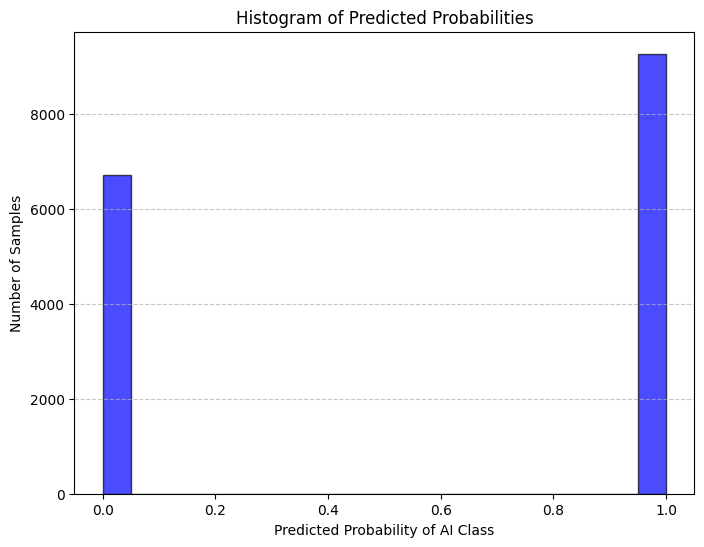

In [21]:
plt.figure(figsize=(8, 6))
plt.hist(pred, bins=20, color="blue", alpha=0.7, edgecolor="black")  # Histogram with 20 bins
plt.xlabel("Predicted Probability of AI Class")
plt.ylabel("Number of Samples")
plt.title("Histogram of Predicted Probabilities")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [22]:
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(val_labels, axis = 1), pred)

0.9101938711694809

In [23]:
# Compute ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(np.argmax(val_labels, axis = 1), pred)

# Compute Youden’s J statistic
youden_j = tpr - fpr
optimal_idx = youden_j.argmax()
optimal_threshold = thresholds[optimal_idx]

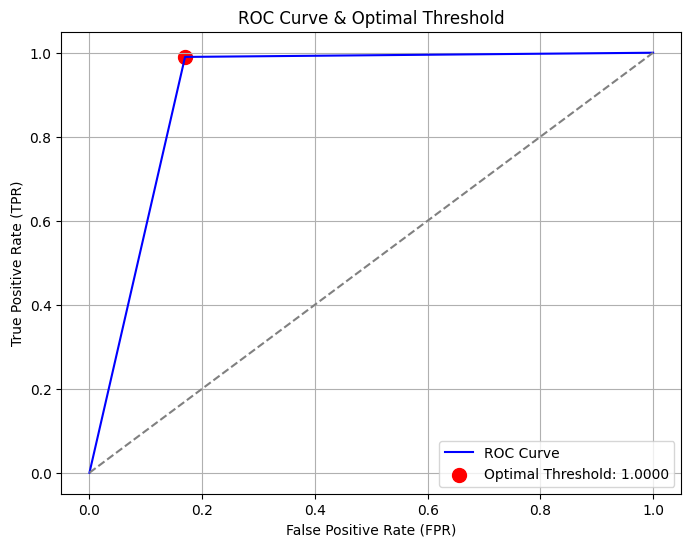

Optimal Probability Threshold: 1.0


In [24]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve", color="blue")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color="red", label=f"Optimal Threshold: {optimal_threshold:.4f}", s=100)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line

# Labels and title
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve & Optimal Threshold")
plt.legend()
plt.grid()
plt.show()

print(f"Optimal Probability Threshold: {optimal_threshold}")

# Test

In [25]:
# Create a TensorFlow dataset for the test images
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = test_ds.map(load_image).batch(BATCH_SIZE)

print("Test dataset loaded successfully!")

NameError: name 'test_paths' is not defined

In [27]:
# Make predictions
predictions = model.predict(test_ds)
predictions = np.argmax(predictions, axis = 1)  # Convert to 1D array

print(f"Min: {np.min(predictions)}, Max: {np.max(predictions)}, Mean: {np.mean(predictions)}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 31s 291ms/step
Min: 0, Max: 1, Mean: 0.39494584837545127


In [28]:
predictions

array([1, 1, 1, ..., 0, 0, 0])

In [30]:
# How many 0s and 1s are predicted
unique, counts = np.unique(predictions, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(3352), np.int64(1): np.int64(2188)}


In [31]:
# Create a submission DataFrame
submission = pd.DataFrame({
    "id": test_df["id"].apply(lambda x: "/".join(x.split("/")[-2:])),  # Use actual test IDs from the dataset
    "label": predictions.flatten().astype(int)  # Convert predictions to integers
})

# Save as CSV without index and header
submission.to_csv("submission.csv", index=False, encoding="utf-8")

print("Predictions saved to 'submission.csv'")

Predictions saved to 'submission.csv'


In [ ]:
df = pd.read_csv("/kaggle/working/submission.csv")
print(df.head())
print(df.dtypes)  # Check if id and label have correct types
df['label'].value_counts()